
<span style="color:darkgreen">Цель: </span></span>Провести предварительную обработку данных и оптимизировать признаковое пространство.

<span style="color:darkgreen">Задачи:</span></span> Выполнить анализ и обработку табличных данных, заполнение пропусков, кодирование категориальных признаков, удаление выбросов и сжатие признакового пространства с помощью метода главных компонент (PCA).

<span style="color:darkgreen"><span style="font-size: 20px;">Импорт библиотек: </span></span>

В первую очередь импортируем все необходимые библиотеки для работы с данными, их обработки и визуализации.
Эти библиотеки включают:

 - pandas и numpy для работы с данными;
 - scipy.stats.zscore для вычисления Z-оценки выбросов;
 - sklearn.impute для обработки пропущенных значений;
 - sklearn.preprocessing и sklearn.decomposition для кодирования и уменьшения размерности;
 - matplotlib и seaborn для визуализации данных.

In [16]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


<span style="color:darkgreen">1. Загрузка данных и первичная оценка</span></span> 

Загружаем данные Titanic и проводим начальную оценку:

- Загружаем данные из CSV-файла.
- Проверяем данные на наличие пропущенных значений и дубликатов.
- Определяем категориальные переменные, чтобы впоследствии закодировать их в числовой формат.

In [ ]:
data = pd.read_csv('titanic.csv')
# Оценка пропусков, дубликатов, категориальных переменных
print("Пропуски в данных:\n", data.isnull().sum())
print("\nКоличество дубликатов:", data.duplicated().sum())

# Определение категориальных переменных
categorical_features = data.select_dtypes(include=['object']).columns
print("\nКатегориальные переменные:", categorical_features)

# Значения категориальных переменных
for feature in categorical_features:
    print(f"\nЗначения для {feature}:\n", data[feature].value_counts())


Пропуски в данных:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Количество дубликатов: 0

Категориальные переменные: Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')

Значения для Name:
 Name
Peter, Master. Michael J                     1
Kelly, Mr. James                             1
Hipkins, Mr. William Edward                  1
Asplund, Master. Carl Edgar                  1
O'Connor, Mr. Patrick                        1
                                            ..
Svensson, Mr. Johan Cervin                   1
Connolly, Miss. Kate                         1
Caldwell, Mr. Albert Francis                 1
Abrahim, Mrs. Joseph (Sophie Halaut Easu)    1
Davies, Mr. John Samuel                      1
Name: count, Length: 418, dtype: int64

Значения для Sex:
 Sex
male      266
female    152


<span style="color:darkgreen">2. Построение и визуализация корреляционной матрицы</span></span> 

Теперь выделяем числовые признаки и построим корреляционную матрицу, чтобы понять зависимости между ними.

Затем визуализируем матрицу с помощью **seaborn** для лучшего восприятия взаимосвязей.


Корреляционная матрица:
              PassengerId    Pclass       Age     SibSp     Parch      Fare
PassengerId     1.000000 -0.026751 -0.034102  0.003818  0.043080  0.008211
Pclass         -0.026751  1.000000 -0.492143  0.001087  0.018721 -0.577147
Age            -0.034102 -0.492143  1.000000 -0.091587 -0.061249  0.337932
SibSp           0.003818  0.001087 -0.091587  1.000000  0.306895  0.171539
Parch           0.043080  0.018721 -0.061249  0.306895  1.000000  0.230046
Fare            0.008211 -0.577147  0.337932  0.171539  0.230046  1.000000


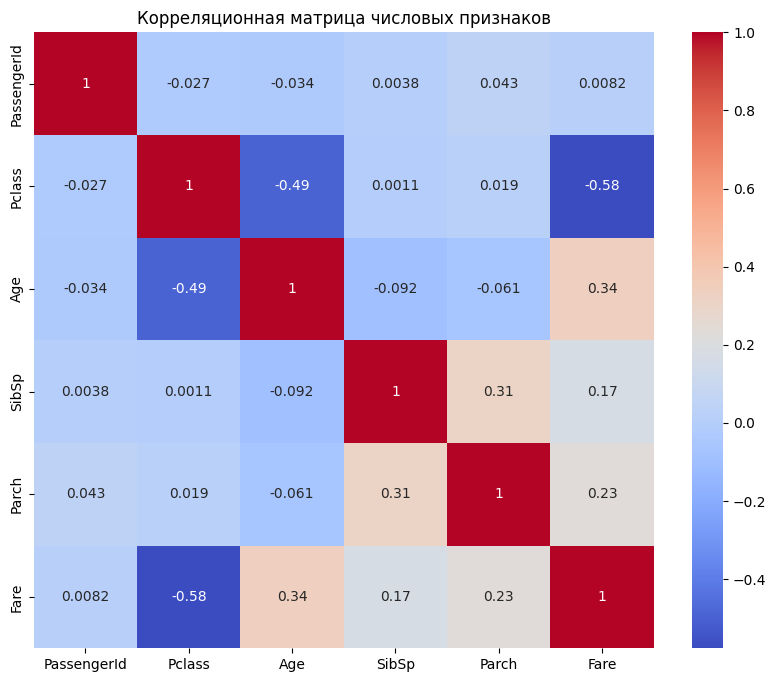

In [18]:
# Корреляционная матрица для числовых столбцов
numeric_data = data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()
print("\nКорреляционная матрица:\n", correlation_matrix)

# Визуализация корреляционной матрицы для лучшего анализа
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Корреляционная матрица числовых признаков")
plt.show()

<span style="color:darkgreen">3. Заполнение пропусков</span></span> 

Заполняем пропущенные значения тремя способами:

 - Медианой для числовых данных. Медиана — устойчивый метод заполнения, так как менее чувствителен к выбросам.
 - Методом KNN, который заполняет пропуски на основе схожих записей, что может улучшить качество заполненных данных.
 - Модой для категориальных данных, чтобы заполнить пропуски наиболее частым значением в столбце.

In [ ]:
# Заполнение пропусков
# a) Медианное заполнение для Age и Fare
imputer_median = SimpleImputer(strategy='median')
data['Age'] = imputer_median.fit_transform(data[['Age']])
data['Fare'] = imputer_median.fit_transform(data[['Fare']])

# b) Заполнение KNN для числовых значений
imputer_knn = KNNImputer(n_neighbors=5)
data[['Age', 'Fare']] = imputer_knn.fit_transform(data[['Age', 'Fare']])

# c) Заполнение модой для Cabin и Embarked (используем .ravel() для одномерного результата)
imputer_mode = SimpleImputer(strategy='most_frequent')
data['Cabin'] = imputer_mode.fit_transform(data[['Cabin']]).ravel()
data['Embarked'] = imputer_mode.fit_transform(data[['Embarked']]).ravel()

<span style="color:darkgreen">4. Кодирование категориальных переменных</span></span> 

Кодирование категориальных признаков для преобразования их в числовой формат:

- One-hot encoding: для переменной Embarked используем метод one-hot, который создает отдельные столбцы для каждой категории.
- Label encoding: переменной Sex присваиваются числовые значения 0 и 1, что упрощает её использование в моделях.
- Target encoding: для переменной Cabin, на основе средней стоимости Fare, чтобы учесть влияние на целевую переменную.

In [ ]:
# Кодирование категориальных переменных
# a) One-hot encoding для Embarked
data = pd.get_dummies(data, columns=['Embarked'], drop_first=True)

# b) Label encoding для Sex
label_encoder = LabelEncoder()
data['Sex'] = label_encoder.fit_transform(data['Sex'])

# c) Target encoding для Cabin с использованием средней стоимости Fare
data['Cabin_encoded'] = data.groupby('Cabin')['Fare'].transform('mean')
data.drop('Cabin', axis=1, inplace=True)


<span style="color:darkgreen">5. Оценка и удаление выбросов</span><span>

Выбросы могут сильно повлиять на модели, поэтому мы:

- Масштабируем числовые данные для их визуализации и лучшего выявления выбросов.
- Используем Z-оценку для выявления выбросов. Записи, где значения выходят за пределы Z-оценки 3, будут считаться выбросами и удаляться из данных.

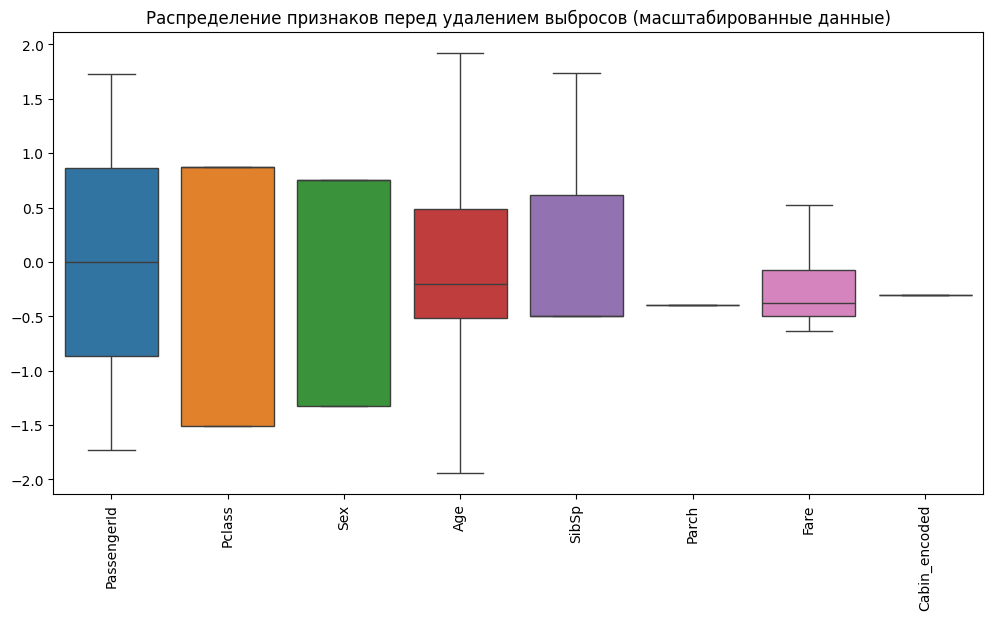

In [ ]:
# Оценка и удаление выбросов
# Выявление выбросов с помощью Z-оценки

# Масштабируем числовые данные для визуализации выбросов
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.select_dtypes(include=[np.number]))
scaled_data_df = pd.DataFrame(scaled_data, columns=data.select_dtypes(include=[np.number]).columns)

# Визуализация выбросов перед удалением (ящик с усами для масштабированных данных)
plt.figure(figsize=(12, 6))
sns.boxplot(data=scaled_data_df, showfliers=False)  # Отключаем отображение точек выбросов
plt.xticks(rotation=90, ticks=range(len(scaled_data_df.columns)), labels=scaled_data_df.columns, fontsize=10)  # Задаем метки для каждого признака с меньшим шрифтом
plt.title("Распределение признаков перед удалением выбросов (масштабированные данные)")
plt.show()


# Удаление выбросов
z_scores = np.abs(zscore(data.select_dtypes(include=[np.number])))
data_clean = data[(z_scores < 3).all(axis=1)].copy()

<span style="color:darkgreen"> 6. Сжатие признаков методом PCA</span><span>

Теперь, после обработки данных и удаления выбросов, применяем **метод главных компонент (PCA)** для уменьшения размерности признакового пространства.

Cнижаем количество признаков до 3 компонент, чтобы визуализировать данные в 3D-пространстве. Этот метод сохраняет основные направления вариаций данных.

In [ ]:
# Сжатие признаков методом PCA до 3 компонент
pca = PCA(n_components=3)
principal_components = pca.fit_transform(data_clean.select_dtypes(include=[np.number]))

# Создаем DataFrame с компонентами PCA и объединяем его с data_clean
pca_df = pd.DataFrame(principal_components, columns=['PCA1', 'PCA2', 'PCA3'], index=data_clean.index)
data_clean = pd.concat([data_clean, pca_df], axis=1)

<span style="color:darkgreen">7. Визуализация данных после PCA</span><span>

Визуализируем результат применения PCA.

Для этого строим 3D-график с тремя компонентами PCA. Цвет точек будет обозначать категориальную переменную Sex, чтобы наглядно увидеть, как разделяются группы в новом пространстве признаков.

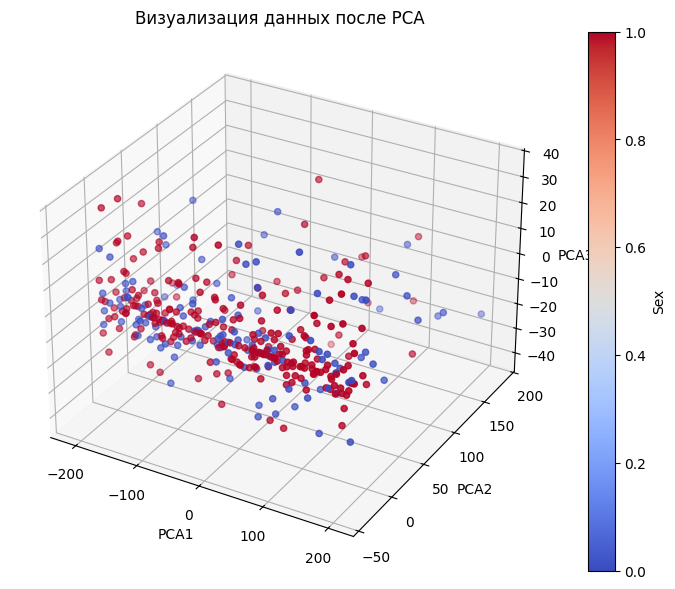

In [23]:
#  Визуализация данных после PCA
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(data_clean['PCA1'], data_clean['PCA2'], data_clean['PCA3'], c=data_clean['Sex'], cmap='coolwarm')
plt.colorbar(sc, label='Sex')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.title("Визуализация данных после PCA")
plt.show()

<span style="color:darkgreen"><span style="font-size: 24px;">**Выводы**</span><span>



Подробные выводы по выполненной работе:

1. **Анализ пропусков и дубликатов**  
   Проведя анализ данных, мы увидели, что в наборе присутствуют пропуски, особенно в таких столбцах, как `Age`, `Fare`, `Cabin`, и `Embarked`. Пропуски в данных могут отрицательно сказаться на моделировании и качестве результатов анализа. Мы также проверили данные на наличие дубликатов, но их не оказалось. Отсутствие дубликатов облегчает работу с данными и говорит о том, что наш набор данных не содержит повторяющихся записей, что могло бы искажать результаты.

2. **Анализ категориальных переменных**  
   Выделение категориальных переменных (`Sex`, `Cabin`, `Embarked`) и их анализ позволили понять, какие из них требуют кодирования. Эти переменные представляют собой текстовые данные, которые необходимо преобразовать в числовой формат для последующего анализа и моделирования. Мы изучили частоты значений для каждой категориальной переменной, чтобы определить, как именно их лучше закодировать.

3. **Корреляционный анализ**  
   Корреляционная матрица числовых признаков показала взаимосвязи между различными характеристиками. Некоторые признаки имеют достаточно сильную корреляцию, например, `Pclass` и `Fare`. В таких случаях корреляция может указывать на дублирование информации между признаками, и это может позволить нам рассмотреть удаление или преобразование этих признаков в дальнейшем. В то же время отсутствие сильных корреляций между большинством признаков говорит о том, что каждый из них может нести уникальную информацию.

4. **Заполнение пропусков**  
   Пропуски были заполнены тремя различными способами: медианой, методом ближайших соседей (KNN) и модой.  
   - Заполнение медианой оказалось полезным для числовых признаков (`Age`, `Fare`), так как медиана устойчива к выбросам.
   - KNN-заполнение предоставило способ заполнения числовых значений на основе схожих записей, что может улучшить качество заполнения для числовых признаков.
   - Заполнение модой для категориальных данных (например, `Cabin` и `Embarked`) позволило сохранить наиболее распространенные категории и было особенно полезно для данных, в которых пропуски составляют значительную часть.

5. **Кодирование категориальных переменных**  
   Для категориальных переменных были использованы три различных метода кодирования:
   - One-hot encoding для переменной `Embarked` позволил избежать присвоения значений ранговой структуры и создал бинарные столбцы для каждой категории, что подходит для номинальных данных.
   - Label encoding для переменной `Sex` оказалось удобным, так как здесь всего две категории (`male` и `female`), и прямое числовое кодирование не нарушает логики данных.
   - Target encoding для `Cabin` с использованием среднего значения `Fare` сохранило информацию о стоимости билета, которая может зависеть от категории `Cabin`. Это добавило дополнительную полезную информацию, не требуя много дополнительных столбцов.

6. **Удаление выбросов**  
   Для анализа выбросов использовалась Z-оценка. Значения, выходящие за пределы 3 стандартных отклонений, были удалены, так как их можно считать аномальными. Удаление выбросов позволило улучшить распределение данных, что может положительно сказаться на моделировании, так как исключение экстремальных значений уменьшает шум и делает данные более репрезентативными для общей популяции.

7. **Сжатие признакового пространства с помощью PCA**  
   Применение метода главных компонент (PCA) позволило уменьшить размерность признакового пространства до 3 компонент. Это полезно для упрощения структуры данных, при этом сохраняя большую часть информации о вариативности данных. PCA выявил наиболее важные направления изменений в данных и позволил лучше понять структуру признаков. Визуализация данных после PCA показала, как данные группируются относительно выбранной переменной `Sex`, что может помочь в дальнейшем анализе и классификации.

8. **Заключение**  
   В результате проделанной работы удалось:
   - Очистить данные от пропусков и выбросов.
   - Преобразовать категориальные переменные в удобный для анализа формат.
   - Сжать признаковое пространство для упрощения дальнейшего анализа.

Проведенные шаги позволили улучшить качество данных, сделать их более пригодными для моделирования и дали представление о возможных связях и особенностях признаков. Эти действия помогут создать более эффективные модели, избежав проблем, связанных с пропусками, выбросами и избыточностью данных.